# Final Report  - Time Series Project

Tarrence Nichols and Nathan Sharick - Innis Cohort

---

### Project Description

- 

### Project Goals

- 

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from env import get_db_url
from sklearn.model_selection import train_test_split
from acquire import get_superstore_df
from acquire import clean_superstore_df

### Acquire, Clean, and Wrangle the dataset

- All data acquisition and data wrangling functions are located in the accompanying acquire.py file

- The get_superstore_df function does...

- The clean_superstore_df does...



In [ ]:
#acquire the dataset using the get_superstore_df function
df = get_superstore_df()
#complete initial cleaning and wrangling of the dataset with the clean_superstore_df function
df = clean_superstore_df(df)

---

### Exploration of Products

- point 1...

- point 2...

- point 3...

- etc...

### Key Takeaways from Product Exploration

- takeaway 1...

- etc...

---

### Exploration of Regional Customer Data

- To better understand our customers and how to market to them we took a top down approach first looking at sales and order values by region and then, starting with the highest priorty region, analyzed individual customers to better understand their shopping and purchasing patterns

- Since we are looking at individual customer patterns we decided that the best approach was to focus on customer segmentation using a RFM analysis so that specific targeted marketing strategies could be developed.

In [7]:
#acquire the dataset with the get_superstore_df function
df = get_superstore_df()
#complete initial data cleaning/wrangling with the clean_superstore_df function
df = clean_superstore_df(df)
#seperate the dataset by region for regional and customer analysis
east = df[df.region == 'East'].copy()
west = df[df.region == 'West'].copy()
central = df[df.region == 'Central'].copy()
south = df[df.region == 'South'].copy()

Reading from CSV file...


#### Visualize yearly sales by region

- To understand which regions we should focus on we visualized yearly total sales and yearly average order value over time

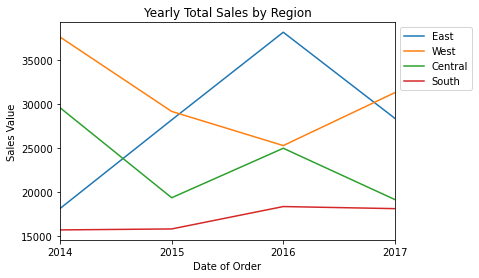

In [8]:
#single out the sales data for each region for visualizations
east_sales = east.sales
west_sales = west.sales
central_sales = central.sales
south_sales = south.sales
##Plot the total yearly sales by region
#plot each region as its own line
east_sales.resample('Y').sum().plot(label='East')
west_sales.resample('Y').sum().plot(label='West')
central_sales.resample('Y').sum().plot(label='Central')
south_sales.resample('Y').sum().plot(label='South')
#add a label to the x_axis
plt.xlabel('Date of Order')
#add a label to the y axis
plt.ylabel('Sales Value')
#add a title to the plot
plt.title('Yearly Total Sales by Region')
#add a legend to the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

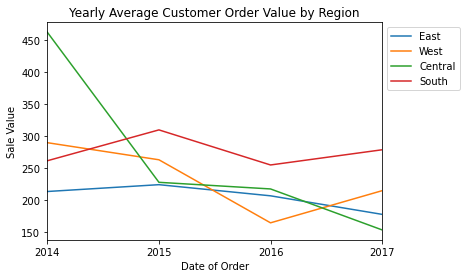

In [9]:
##Plot the average order value per year by region
#plot each region as its own line
east_sales.resample('Y').mean().plot(label='East')
west_sales.resample('Y').mean().plot(label='West')
central_sales.resample('Y').mean().plot(label='Central')
south_sales.resample('Y').mean().plot(label='South')
#add a label to the x axis
plt.xlabel('Date of Order')
#add a label to the y axis
plt.ylabel('Sale Value')
#add a title to the plot
plt.title('Yearly Average Customer Order Value by Region')
#add a legend to the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

#### RFM Analysis (Recency, Frequency, Monetary)

- To better understand how to approach our customers in the central region with targeted marketing, we conducted a RFM analysis which evaluates how long its been since the customers last order, how many orders the customer has made, and what the total sales value of the customers orders were to segment them into focus groups.

In [10]:
##RFM Analysis##
#create a new dataframe with customer name and sales for all orders from the central region
central_cust_sales = central[['cust_name', 'sales']].copy()
#add a column that contains the data of the most recent order made by the customer
central_cust_sales['last_purchase'] = central_cust_sales['cust_name'].apply(lambda x: central_cust_sales[central_cust_sales['cust_name'] == x].index.max())
#set a 'today' variable to calculate how many days since the customers last order
today = pd.to_datetime('2017-12-30') 
#add a column for recency with the number of days since the customers last order
central_cust_sales['recency'] = central_cust_sales['last_purchase'].apply(lambda x: (today - x).days)
#add a column for frequency with the total number of orders the customer has made
central_cust_sales['frequency'] = central_cust_sales['cust_name'].apply(lambda x: central_cust_sales[central_cust_sales['cust_name'] == x].size)
#add a column for monetary with the total sales value for all that customers orders
central_cust_sales['monetary'] = central_cust_sales['cust_name'].apply(lambda x: central_cust_sales[central_cust_sales['cust_name'] == x].sales.sum())
#drop the sales and last purchase columns that were used to calculate the other columns
central_customer_rating = central_cust_sales.drop(columns=['sales', 'last_purchase'])
#group the dataframe by customer name to remove duplicate rows
central_customer_rating = central_customer_rating.groupby('cust_name').max()

#rank the customers in each of the three categories (recency, frequency, monetary)
central_customer_rating['r_rank'] = central_customer_rating['recency'].rank(ascending=False)
central_customer_rating['f_rank'] = central_customer_rating['frequency'].rank(ascending=True)
central_customer_rating['m_rank'] = central_customer_rating['monetary'].rank(ascending=True)
#normalize the rankings for overall scoring
central_customer_rating['r_rank_norm'] = (central_customer_rating['r_rank']/central_customer_rating['r_rank'].max())*100
central_customer_rating['f_rank_norm'] = (central_customer_rating['f_rank']/central_customer_rating['f_rank'].max())*100
central_customer_rating['m_rank_norm'] = (central_customer_rating['m_rank']/central_customer_rating['m_rank'].max())*100
#drop the original rank columns used for calculations
central_customer_rating.drop(columns=['r_rank', 'f_rank', 'm_rank'], inplace=True)

#calculate the customers rfm score
central_customer_rating['rfm_score'] = (0.15*central_customer_rating['r_rank_norm'])+(0.28*central_customer_rating['f_rank_norm'])+(0.57*central_customer_rating['m_rank_norm'])
#change the rfm score to a score between 0 and 5
central_customer_rating['rfm_score'] *= 0.05
#round the customers rfm score to 2 decimal places
central_customer_rating.rfm_score = central_customer_rating.rfm_score.round(2)

#add a column that groups customers into overall rating groups
central_customer_rating['overall_customer_rating'] = pd.cut(central_customer_rating.rfm_score, bins=[0, 1.6, 3, 4, 4.5, 5], labels=['lost customer', 'low value customer', 'moderate value customer', 'high value customer', 'top customer'])
#add a column that groups customers by recency ranking
central_customer_rating['recency_rating'] = pd.cut(central_customer_rating.recency, bins=[0, 180, 360, 1500 ], labels=['high', 'moderate', 'low'])
#add a column that groups customers by frequency rating
central_customer_rating['frequency_rating'] = pd.cut(central_customer_rating.frequency, bins=[0, 13, 23, 33], labels=['low', 'moderate', 'high'])
#add a column that groups customers by monetary rating
central_customer_rating['monetary_rating'] = pd.cut(central_customer_rating.monetary, bins=[0, 1000, 5000, 11000], labels=['low', 'moderate', 'high'])
#drop the normalized rank columns used to calculate customer groupings
central_customer_rating.drop(columns=['r_rank_norm', 'f_rank_norm', 'm_rank_norm'], inplace=True)
#view the resulting dataframe
central_customer_rating


,recency,frequency,monetary,rfm_score,overall_customer_rating,recency_rating,frequency_rating,monetary_rating
cust_name,,,,,,,,
Aimee Bixby,41,16,138.696,3.20,moderate value customer,high,moderate,low
Alan Dominguez,1100,4,600.558,2.62,low value customer,low,low,low
Alejandro Ballentine,552,4,13.616,0.94,lost customer,low,low,low
Alex Avila,184,8,374.480,3.29,moderate value customer,moderate,low,low
Alice McCarthy,532,8,57.240,1.96,low value customer,low,low,low
...,...,...,...,...,...,...,...,...
Tracy Blumstein,107,4,19.050,1.31,lost customer,high,low,low
Tracy Hopkins,187,12,564.380,3.79,moderate value customer,moderate,low,low
Troy Blackwell,285,4,2.910,0.90,lost customer,moderate,low,low


### Key Takeaways from Customer Exploration and Analysis

- The central region had the largest drop in total sales between the beginning of 2014 and the end of 2017 

- The central region also had the highest average order value in 2014 and the lowest average order value in 2017 compared to all other regions

- The above observations make the central region a priority for our marketing team's attention

- We have 1 customer with a "Top Customer" rating and and 16 customers with a "High Value Customer" rating in the central region meaning they have above a 4 for a rfm score

- We have 46 customers with a "High" recency rating meaning their last order was within the last 6 months

- We have 110 customers with a "Low" recency rating meaning they have not made an order in the last year

- We have 8 customers with a "High" frequency rating meaning they have made more than 23 orders with our company

- We have 2 customers with a "High" monetary rating meaning they have a total order value of more than $5000.00 with our company

- Each of the above customer groups represent a focus area for targeted marketing


---

### Summary

- point 1...

- etc...


### Marketing Recomendations

- **Recomendations based on product research**

    - Recomendation 1....
    
    - Recomendation 2...
    
- **Recomendations based on customer research**

    - Customers with a "Top Customer" or "High Value Customer" rating are our best customers and would most likely respond well to marketing focused on loyalty programs or early access to new products
    
    - Customers with a "High" frequency rating may not be the highest spending customers but they make purchases most often and would most likely respond well to marketing focused on free shipping or similar offers
    
    - Customers with a "High" monetary rating are our big spending customers and will most likely respond to marketing focued on luxury offers or higher level subscription tiers
    
    - Customers with a "High" recency rating have made an order with us in the last 6 months so we are on their mond and we should focus marketing on keeping us on their mind with new peodut anouncements or recomendations based on their recent purchases
    
    - Customers with a "Low" recency rating have not made an order with us in the last year and are at risk of not coming back. they should be targeted with marketed focused on retension such as discount pricing or with specific customer engagement efforts
    

### Next Steps

- next step 1...

- If we had more time to analyze customer groups we would conduct a RFM analysis on the other 3 regions to identify focus groups for targeted marketing in those regions